**Imports**

In [9]:
from __future__ import division
import scipy.constants as const
import math
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
%matplotlib inline

**Constants, defaults, etc.**

Sampling rate set to 44.1KHz

Number of unique notes set to 88 (source: wikipedia)

In [10]:
rate = 44100 #44.1 khz
key2freq = lambda n : 2 ** ((n+1-49)/12) * 440 # convert a piano key n to a frequency in Hz
num_notes = 88
wav_file = "fur_elise.wav"

# Bi-directional mapping between keys and frequencies
key2frequency = {i : key2freq(i) for i in range(88)}
frequency2key = {key2frequency[key] : key for key in key2frequency}

** Output **

Playing the actual music

In [11]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def playMusic(title, rate, music):
    # write the file on disk, and show in in a Html 5 audio player
    music_wav = music * 2**13
    wavfile.write(title + '.wav', rate, music_wav.astype(np.int16))
    wavPlayer(title + '.wav')

** LOGIC **

Implementing the Markov model

In [12]:
def song_from_notes(notes):
    """Converts a list of notes into a playable song"""
    
    note_duration = 0.5 # per key, in sec
    music_duration = note_duration * len(notes)
    time = np.linspace(0, music_duration, num=rate*music_duration) # indices for 0-16 secs spaced apart by 1/44100
    song = np.zeros(len(time))

    sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t

    idx_note = 0
    for note in notes:
        if note: # if note == 0, skip.
            freq = key2freq(note) # frequency of each note
            song[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1] = \
                    sinwave(freq,
                            time[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1 ] 
                            ) #generates the sinusoids for the song, in .5 sec intervals
        idx_note += 1
        
    return song

Array fur_elise.wav
shape: (7713792, 2)
dtype: int16
min, max: -20017 17591

note length:0.197415

/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



852
[55, 55, 54, 54, 55, 54, 55, 50, 53, 51, 51, 48, 43, 43, 39, 43, 48, 50, 50, 47, 47, 47, 47, 47, 51, 47, 36, 43, 55, 54, 55, 54, 55, 50, 53, 51, 51, 48, 43, 39, 39, 43, 43, 50, 43, 43, 43, 51, 50, 48, 48, 43, 43, 43, 55, 54, 55, 55, 55, 55, 53, 53, 51, 48, 48, 43, 39, 43, 43, 50, 50, 50, 43, 47, 47, 47, 47, 47, 36, 43, 55, 54, 55, 54, 55, 50, 53, 53, 48, 48, 48, 39, 39, 43, 43, 50, 50, 43, 43, 43, 50, 48, 48, 43, 43, 51, 51, 53, 55, 46, 39, 46, 56, 55, 55, 53, 53, 38, 44, 44, 53, 53, 43, 43, 43, 53, 53, 50, 50, 50, 43, 43, 55, 43, 55, 55, 55, 54, 55, 54, 54, 55, 54, 55, 55, 55, 55, 54, 55, 54, 55, 50, 53, 51, 48, 48, 43, 39, 39, 43, 50, 50, 43, 43, 43, 47, 47, 47, 47, 36, 43, 55, 54, 54, 54, 54, 55, 50, 53, 51, 48, 43, 43, 39, 43, 43, 50, 50, 43, 43, 43, 51, 50, 48, 43, 43, 50, 51, 53, 55, 55, 39, 39, 56, 55, 55, 53, 53, 38, 44, 44, 53, 51, 43, 43, 43, 53, 53, 50, 50, 43, 43, 55, 43, 55, 55, 55, 55, 54, 55, 54, 55, 55, 54, 55, 54, 55, 54, 55, 54, 55, 55, 50, 51, 51, 48, 43, 43, 39

/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


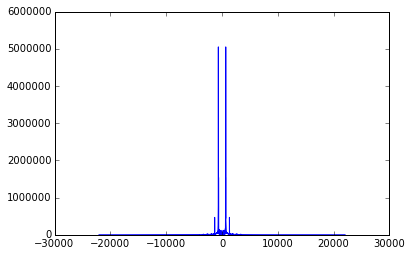

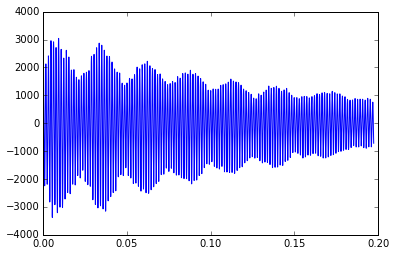

In [16]:
def notes_from_wav(wav_file):
    """Converts a wav file to a list of notes"""
    rate, data = scipy.io.wavfile.read(wav_file)
    show_info(wav_file, data)
    freqs = convert_signal_to_freqs(data, rate)
    formatted_freqs = nearest_piano_freq(freqs, key2frequency.values())
    notes = [frequency2key[freq] for freq in formatted_freqs]
    return notes

def show_info(aname, a):
    print "Array", aname
    print "shape:", a.shape
    print "dtype:", a.dtype
    print "min, max:", a.min(), a.max()
    print

def convert_signal_to_freqs(data, rate):
    t = np.linspace(0, (len(data)-1)/rate, len(data))
    song = (data[:, 1] + data[:,0])/2
    
    window_size = 8706.0
    note_length = window_size/rate
    print"note length:%f" %note_length
    num_windows = math.ceil(len(song)/window_size)
    
    ffts = []
    bins = []
    freq_lists = []
    f = lambda x :np.linspace(-0.5*rate, 0.5*rate, x)
    tx = lambda x :np.linspace(0, note_length, x)

    i = 0
    while i < len(t):
        if i+window_size >= len(t):
            curr_fft = np.fft.fft(song[i:])
            curr_bin = song[i:]
        else:
            curr_fft = np.fft.fftshift(abs(np.fft.fft(song[i:i+window_size])))
            curr_bin = song[i:i+window_size]
        freqs = f(len(curr_fft))
        highestMagIndices = np.where(curr_fft == max(curr_fft))
        curr_freq = abs(freqs[highestMagIndices[0][0]])
        freq_lists.append(curr_freq)
        ffts.append(curr_fft)
        bins.append(curr_bin)
        i += window_size

    filtered_list = [freq for freq in freq_lists if freq > 25 and freq < 4200]
    print len(filtered_list)
    
    assert num_windows == len(ffts)
    index = 7
    plt.figure()
    plt.plot(f(len(ffts[index])), ffts[index])
    plt.figure()
    plt.plot(tx(len(bins[index])), bins[index])
    return filtered_list

def nearest_piano_freq(freqs, standard_freqs):
    formatted_freqs = []
    for freq in freqs:
        check_list = [abs(f - freq) for f in standard_freqs]
        min_index = check_list.index(min(check_list))
        formatted_freqs.append(standard_freqs[min_index])
    return formatted_freqs

fur_elise_notes = notes_from_wav(wav_file)
print fur_elise_notes

In [68]:
def stochastic_matrix(*note_lists, **kwargs):
    """Calculates the stochastic matrix from all of the note lists
    and for a Markov model of the given degree"""
    
    degree = kwargs['degree']
    matrix = np.zeros((num_notes**degree,num_notes**degree))
    
    for notes in note_lists:
        for i in range(len(notes)):
            
            curr_note_sequence = notes[i:i+degree]
            
            # Calculate the index
            curr_seq_index = notes2index(curr_note_sequence)
                        
            if i < len(notes)-degree:
                # Get next note
                next_note = notes[i+degree]
                next_note_sequence = curr_note_sequence[1:] + [next_note]
                next_seq_index = notes2index(next_note_sequence)
                
                # increment count for element of stochastic matrix
                matrix[curr_seq_index][next_seq_index] += 1
                
    return normalize(matrix)

def normalize(matrix):
    """Normalizes matrix rows"""
    
    row_sums = matrix.sum(axis=1)
    matrix = matrix / row_sums[:, np.newaxis]
    return matrix
    
def notes2index(note_sequence):
    """Calculates the index of the stochastic matrix for the given sequence of notes,
    generalized to n notes. Does this by mapping base-88 to base-10"""
    return sum([note_sequence[i]*(88**i) for i in range(len(note_sequence)-1, -1, -1)])

notes = [47, 47, 49, 49, 47, 47]
test = stochastic_matrix(notes, degree=1)

/Users/Ujval/Documents/berkeley/ee126/venv/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide


In [8]:
def random_walk(stoch_matrix, size):
    initial_note = 47
    distribution = stoch_matrix[initial_note]
    result = np.array([initial_note])
    for i in range(1, size):
        x = np.sum(distribution)
        if not x:
            next_val = np.random.choice(np.arange(0,88))
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val]
        else:
            next_val = np.random.choice(np.arange(0,88), 1, p = distribution)
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val[0]]
    return result

**MAIN**

Putting everything together

In [11]:
# Get notes from wav
notes = notes_from_wav(wavfile)
notes = [np.random.choice(range(88)) for i in range(100)]
notes = [47, 47, 49, 49, 47, 47, 44, 44, 47, 47, 44, 44, 42, 42, 42, 0, 47, 47, 49, 49, 47, 47, 44, 44, 47, 44, 42, 44, 40, 40, 40, 0]# Calculate stochastic matrix
notes2 = [47, 42, 44, 40, 39, 40, 39]# Calculate stochastic matrix

matrix = stochastic_matrix(1, notes, notes2)

# Create a random walk of notes, starting from a particular note
generated_song_notes = random_walk(matrix, len(notes))

# play song for notes
playMusic("test1", rate, song_from_notes(generated_song_notes))
playMusic("test2", rate, song_from_notes(notes2))

/Users/Ujval/Documents/berkeley/ee126/venv/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


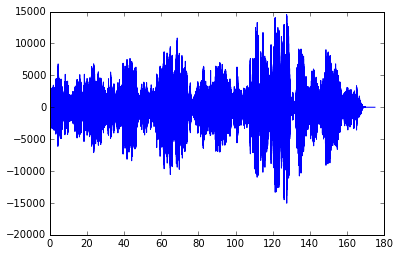

In [29]:
rate, track1_data = wavfile.read("/Users/Ujval/Documents/berkeley/ee126/proj/markovian-music/fur_elise.wav") #import song

flattened = (track1_data[:, 1] + track1_data[:,0])/2
frequencies = abs(np.fft.fft(flattened))

t = np.linspace(0, (len(track1_data)-1)/rate, len(track1_data))
plt.plot(t, flattened)
plt.show()

#playMusic('gymnopedie1_played', rate, data_song1)